In [27]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)




def y_fdm(gamma, y_i):
    v_i = y_i / (2 * tau_i)
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000)
    sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                    method='RK45', t_eval=tau_arr, 
                    rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
    if sol.t_events[0].size > 0:
        tau_ta = sol.t_events[0][0]
        y_ta = sol.y_events[0][0][0]
        return sol, (y_i, tau_ta, y_ta)  
    return sol, None  


def yta_true_min(gamma, initial_y_i):
    y_i = initial_y_i
    true_yi = y_i 
    initial_y_ta = float('inf') 
    initial_tau_ta = None
    min_found = False

    #print(f"\n**Finding the true minima of y_ta for gamma = {gamma:.2e}**")
    while not min_found:
        sol, turnaround_point = y_fdm(gamma, y_i)
        if not turnaround_point:
            break 
        y_i, tau_ta, y_ta = turnaround_point  
        print(f" y_i = {y_i:.4e}, tau_ta = {tau_ta:.4e}, y_ta = {y_ta:.4e}")
        if y_ta < initial_y_ta:
            initial_y_ta = y_ta
            initial_tau_ta = tau_ta
            true_yi = y_i  
            y_i *= 0.9 
        else:
            min_found = True  
    stable_yi = true_yi  
    stable_yta_min = initial_y_ta   
    while True:
        yi_up = stable_yi * 1.01  
        yi_down = stable_yi * 0.99  
        sol_up, turnaround_up = y_fdm(gamma, yi_up)
        sol_down, turnaround_down = y_fdm(gamma, yi_down)
        
        if not turnaround_up or not turnaround_down:
            break  

        yi_up, tau_ta_up, y_ta_up = turnaround_up
        yi_down, tau_ta_down, y_ta_down = turnaround_down

        #print(f"Stabilizing: after increasing -> y_i = {yi_up:.4e}, y_ta = {y_ta_up:.4e}")
       # print(f"Stabilizing: after decreasing -> y_i = {yi_down:.4e}, y_ta = {y_ta_down:.4e}")

        if y_ta_up < stable_yta_min:
            stable_yta_min = y_ta_up
            initial_tau_ta = tau_ta_up
            stable_yi = yi_up
        elif y_ta_down < stable_yta_min:
            stable_yta_min = y_ta_down
            initial_tau_ta = tau_ta_down
            stable_yi = yi_down
        else:
            break  

    print(f"\n**Final true minima:** gamma = {gamma:.2e}, y_i = {stable_yi:.4e}, tau_ta = {initial_tau_ta:.4e}, y_ta = {stable_yta_min:.4e}\n")

    return gamma, stable_yi, initial_tau_ta, stable_yta_min



**Finding the true minima of y_ta for gamma = 1.00e-10**
 y_i = 7.7426e-11, tau_ta = 6.2100e-15, y_ta = 4.0057e-10
 y_i = 6.9684e-11, tau_ta = 4.3851e-15, y_ta = 3.0831e-10
 y_i = 6.2715e-11, tau_ta = 3.5174e-15, y_ta = 2.4110e-10
 y_i = 5.6444e-11, tau_ta = 2.5392e-15, y_ta = 1.9460e-10
 y_i = 5.0799e-11, tau_ta = 1.9849e-15, y_ta = 1.6053e-10
 y_i = 4.5719e-11, tau_ta = 1.6554e-15, y_ta = 1.3628e-10
 y_i = 4.1148e-11, tau_ta = 1.5271e-15, y_ta = 1.1949e-10
 y_i = 3.7033e-11, tau_ta = 1.2230e-15, y_ta = 1.0918e-10
 y_i = 3.3330e-11, tau_ta = 1.5510e-15, y_ta = 1.0584e-10
 y_i = 2.9997e-11, tau_ta = 1.4566e-15, y_ta = 1.1093e-10
Stabilizing: after increasing -> y_i = 3.3663e-11, y_ta = 1.0602e-10
Stabilizing: after decreasing -> y_i = 3.2996e-11, y_ta = 1.0566e-10
Stabilizing: after increasing -> y_i = 3.3326e-11, y_ta = 1.0584e-10
Stabilizing: after decreasing -> y_i = 3.2666e-11, y_ta = 1.0630e-10

**Final true minima:** gamma = 1.00e-10, y_i = 3.2996e-11, tau_ta = 1.2002e-15, y_ta 

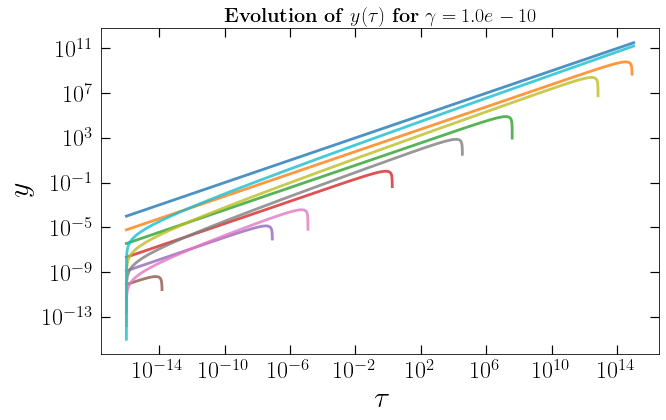

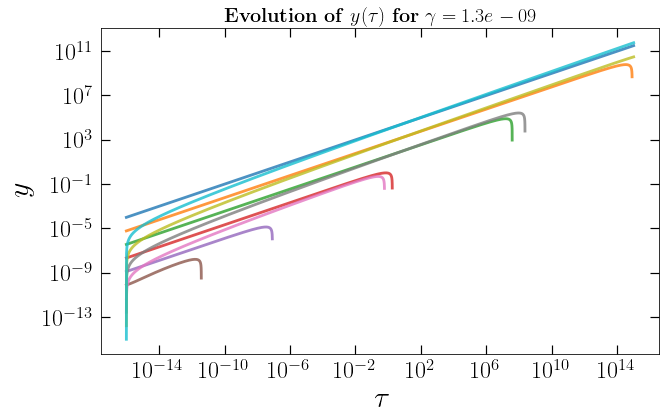

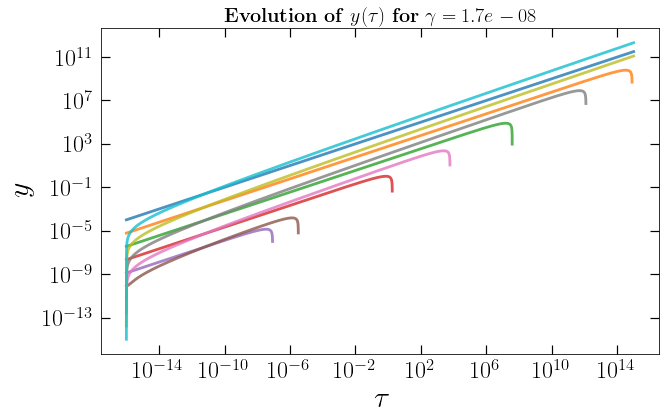

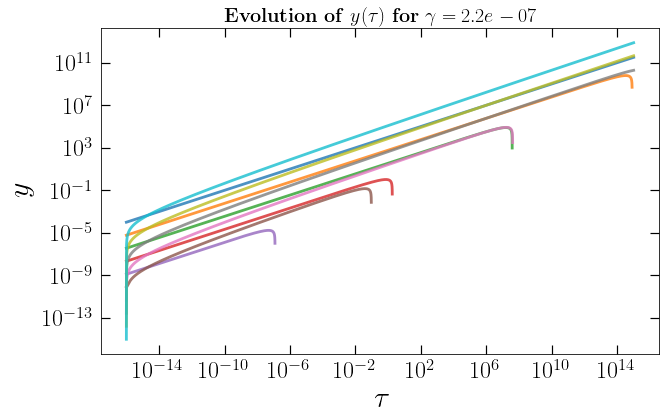

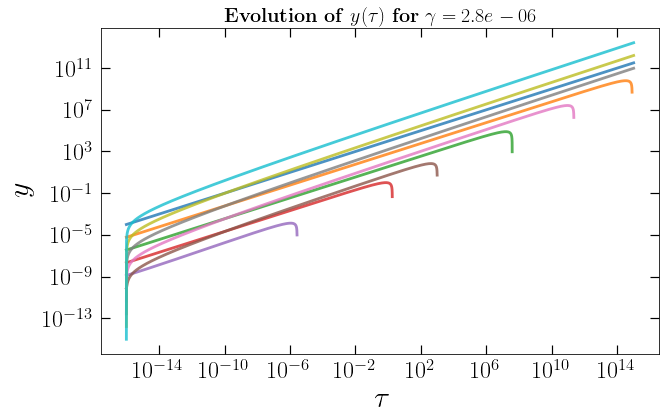

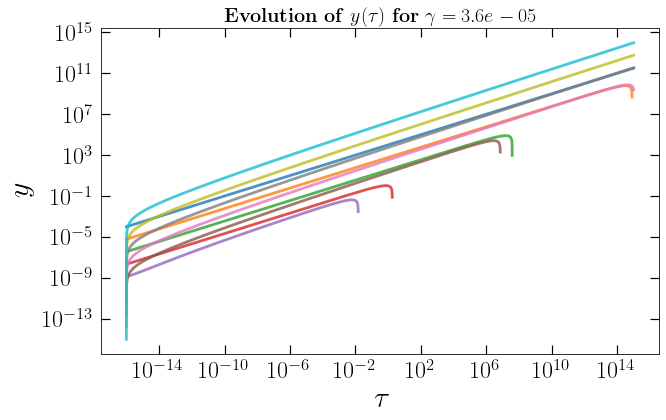

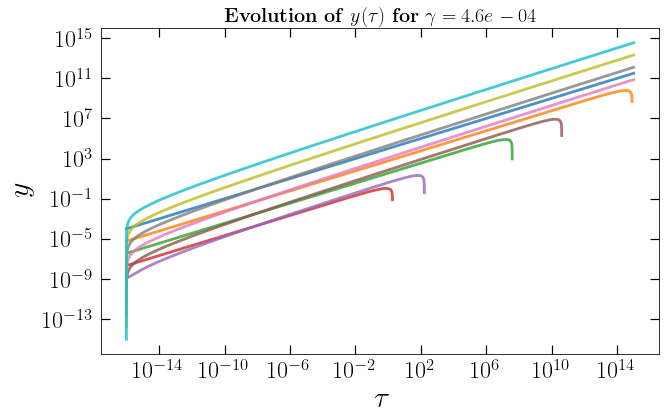

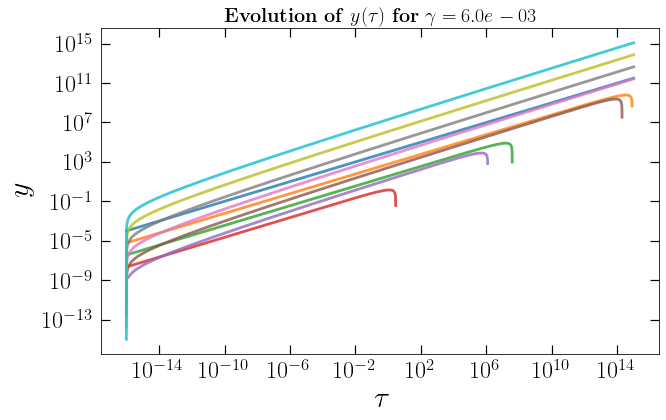

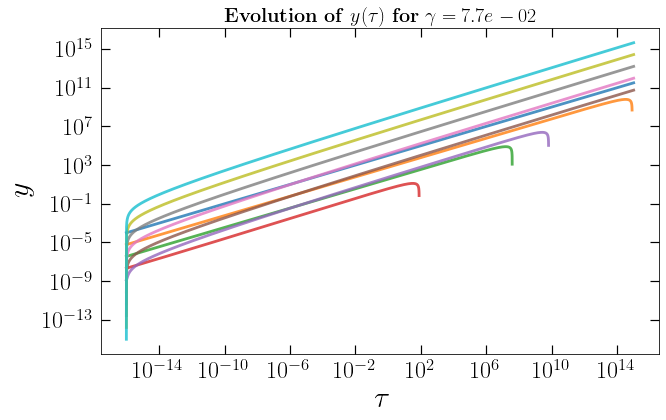

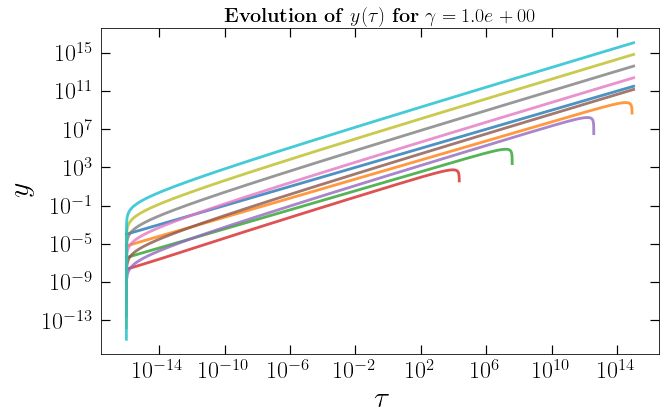

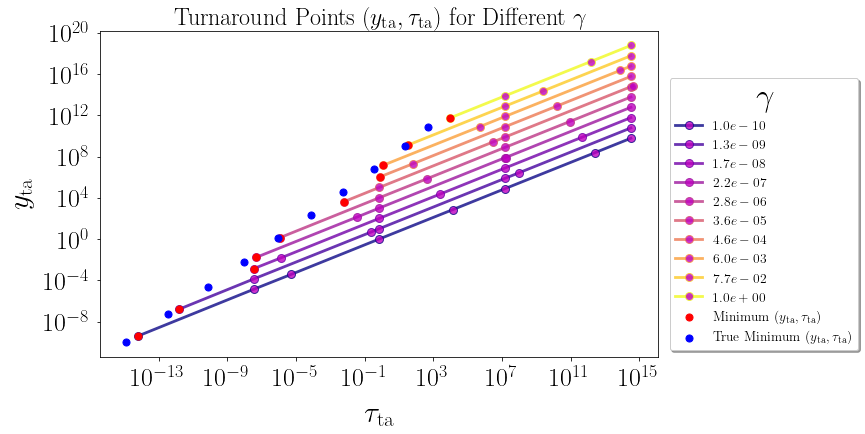

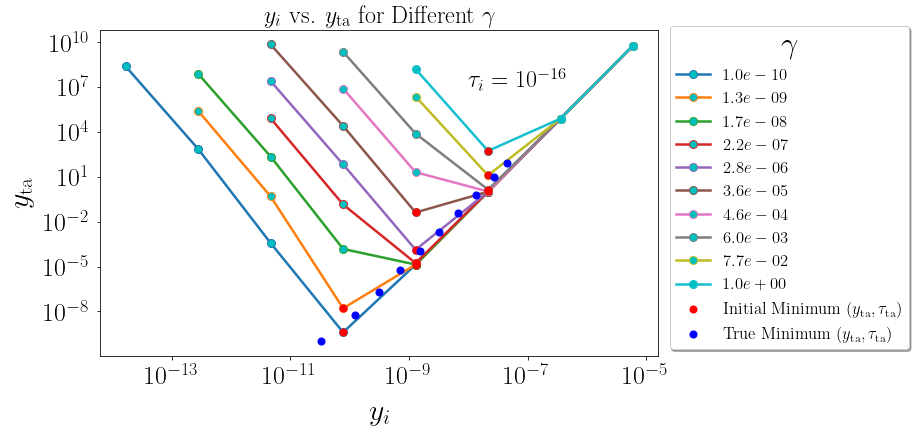

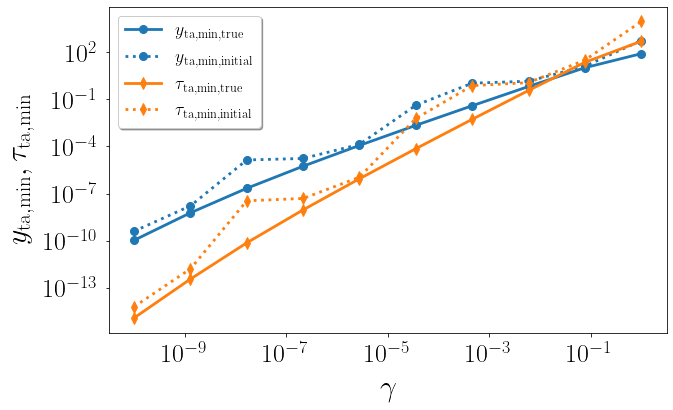


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 7.7426e-11, Tau_ta: 6.2100e-15, Y_ta: 4.0057e-10
Gamma: 1.3e-09, Y_i: 7.7426e-11, Tau_ta: 1.6026e-12, Y_ta: 1.6295e-08
Gamma: 1.7e-08, Y_i: 1.2915e-09, Tau_ta: 3.4594e-08, Y_ta: 1.3750e-05
Gamma: 2.2e-07, Y_i: 1.2915e-09, Tau_ta: 4.8786e-08, Y_ta: 1.7185e-05
Gamma: 2.8e-06, Y_i: 1.2915e-09, Tau_ta: 1.1046e-06, Y_ta: 1.3496e-04
Gamma: 3.6e-05, Y_i: 1.2915e-09, Tau_ta: 6.0144e-03, Y_ta: 4.1930e-02
Gamma: 4.6e-04, Y_i: 2.1544e-08, Tau_ta: 7.4338e-01, Y_ta: 1.0631e+00
Gamma: 6.0e-03, Y_i: 2.1544e-08, Tau_ta: 1.1541e+00, Y_ta: 1.4205e+00
Gamma: 7.7e-02, Y_i: 2.1544e-08, Tau_ta: 3.1545e+01, Y_ta: 1.2758e+01
Gamma: 1.0e+00, Y_i: 2.1544e-08, Tau_ta: 9.0309e+03, Y_ta: 5.5363e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.2996e-11, Tau_ta: 1.2002e-15, Y_ta: 1.0566e-10
Gamma: 1.3e-09, Y_i: 1.2237e-10, Tau_ta: 3.5922e-13, Y_ta: 5.9344e-09
Gamma: 1.7e-08, Y_i: 3.1220e-10, Tau_ta: 7.2918e-11, Y_ta: 2.1604e-07
Gamma: 2.2e-

In [28]:
gamma_values = np.geomspace(1e-10, 1, 10) 
yi_values = np.geomspace(1e-4, 1e-15, 10)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
for gamma in gamma_values:
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    for y_i in yi_values:
        sol, turnaround = gamma_results[gamma][y_i] 
        tau_vals, y_vals = sol.t, sol.y[0]
        ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
#seen_points = set()  # Avoid duplicate points
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points)  
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")


ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.02), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta3.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.02), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta3.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr, marker='o', markersize=8, color='C0', ls='-', label="Refined $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr, marker='o',  markersize=8, color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr, marker='d',  markersize=8, color='C1', ls='-', label="Refined $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("ytamin_vs_gamma3.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Finding the true minima of y_ta for gamma = 1.00e-10**
 y_i = 3.0888e-11, tau_ta = 1.3839e-15, y_ta = 1.0876e-10
 y_i = 2.7800e-11, tau_ta = 1.7736e-15, y_ta = 1.2001e-10
Stabilizing: after increasing -> y_i = 3.1197e-11, y_ta = 1.0838e-10
Stabilizing: after decreasing -> y_i = 3.0580e-11, y_ta = 1.0896e-10
Stabilizing: after increasing -> y_i = 3.1509e-11, y_ta = 1.0747e-10
Stabilizing: after decreasing -> y_i = 3.0885e-11, y_ta = 1.0876e-10
Stabilizing: after increasing -> y_i = 3.1824e-11, y_ta = 1.0743e-10
Stabilizing: after decreasing -> y_i = 3.1194e-11, y_ta = 1.0839e-10
Stabilizing: after increasing -> y_i = 3.2143e-11, y_ta = 1.0721e-10
Stabilizing: after decreasing -> y_i = 3.1506e-11, y_ta = 1.0748e-10
Stabilizing: after increasing -> y_i = 3.2464e-11, y_ta = 1.0681e-10
Stabilizing: after decreasing -> y_i = 3.1821e-11, y_ta = 1.0743e-10
Stabilizing: after increasing -> y_i = 3.2789e-11, y_ta = 1.0603e-10
Stabilizing: after decreasing -> y_i = 3.2139e-11, y_ta = 1.0722e-1

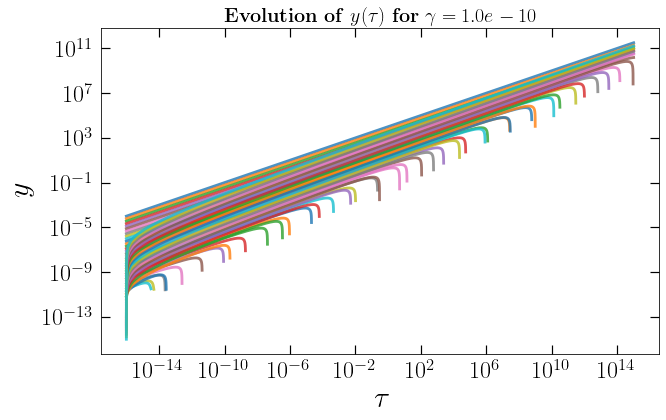

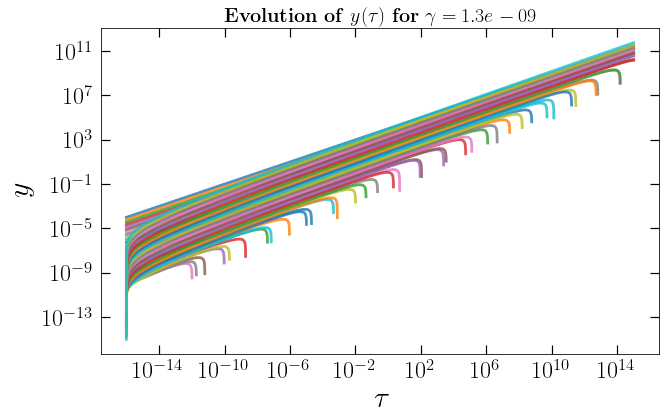

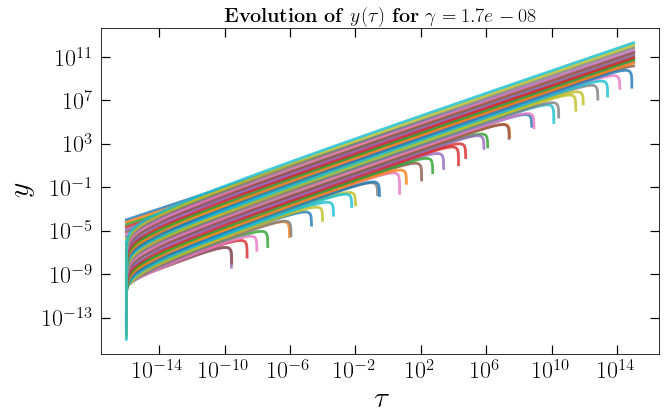

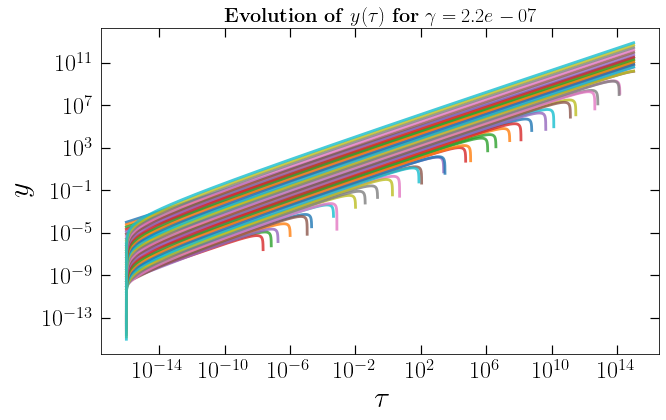

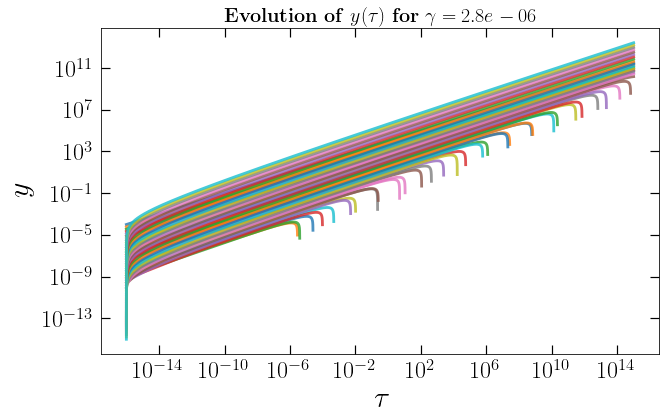

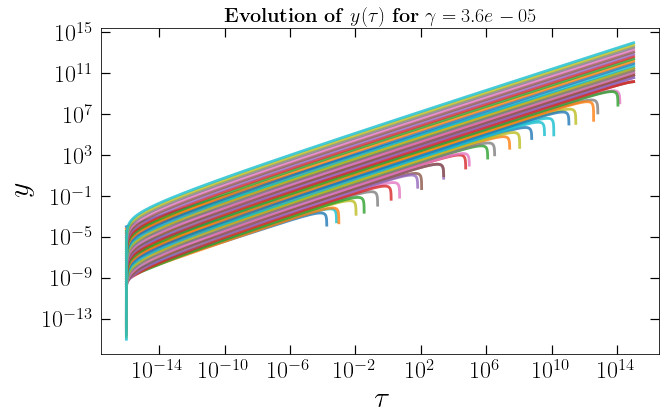

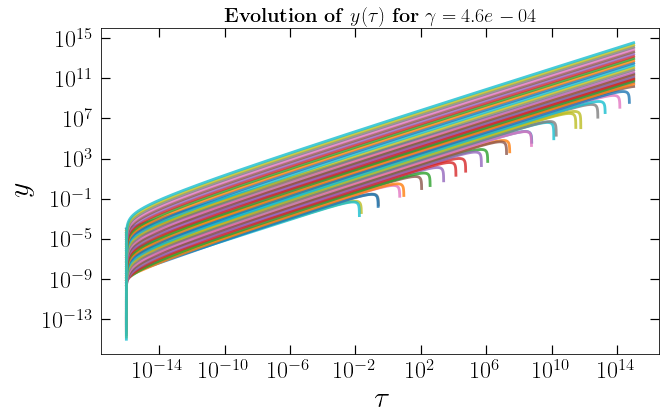

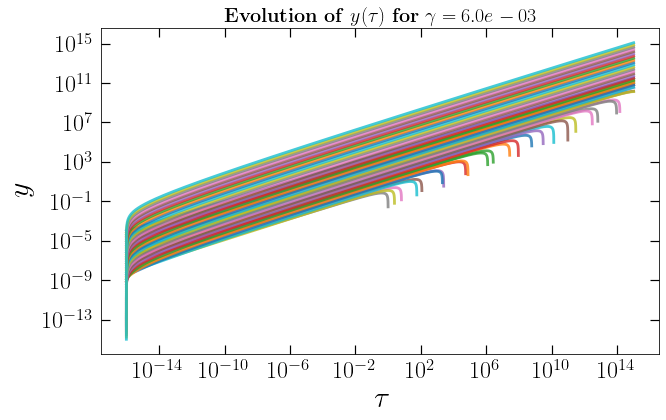

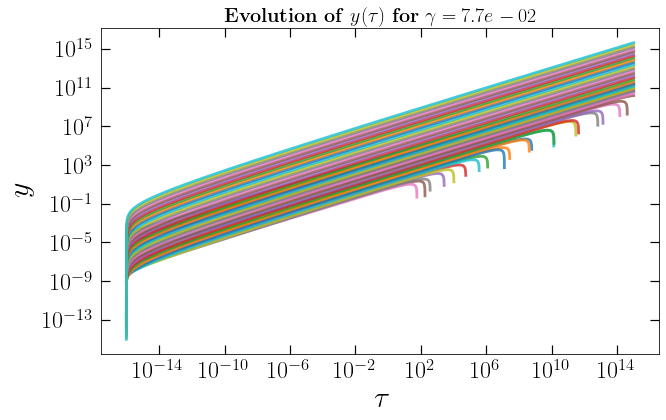

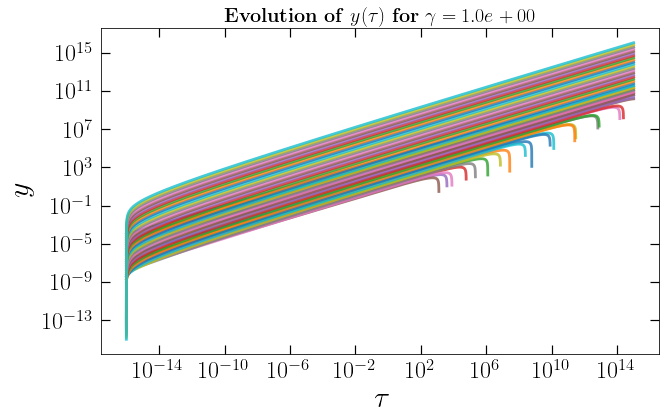

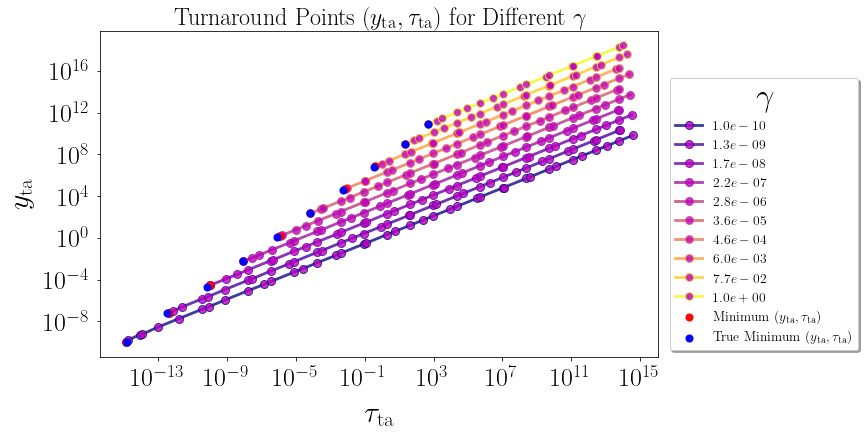

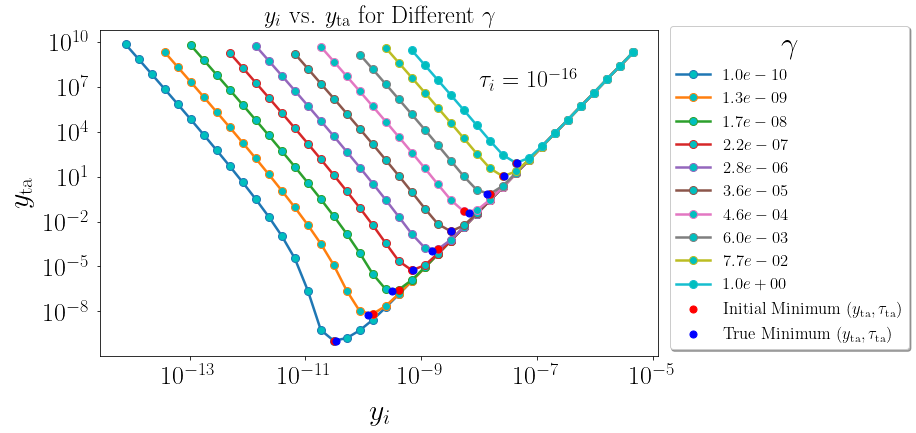

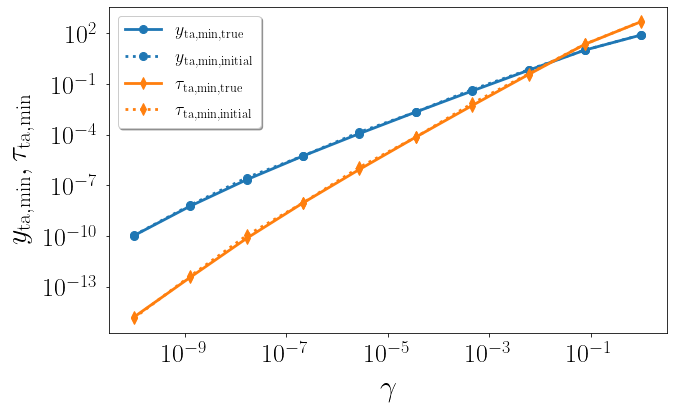


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.0888e-11, Tau_ta: 1.3839e-15, Y_ta: 1.0876e-10
Gamma: 1.3e-09, Y_i: 1.4563e-10, Tau_ta: 4.2158e-13, Y_ta: 6.7463e-09
Gamma: 1.7e-08, Y_i: 4.0949e-10, Tau_ta: 1.0700e-10, Y_ta: 2.8390e-07
Gamma: 2.2e-07, Y_i: 6.8665e-10, Tau_ta: 9.2887e-09, Y_ta: 5.5542e-06
Gamma: 2.8e-06, Y_i: 1.9307e-09, Tau_ta: 1.1668e-06, Y_ta: 1.4164e-04
Gamma: 3.6e-05, Y_i: 3.2375e-09, Tau_ta: 7.1941e-05, Y_ta: 2.2038e-03
Gamma: 4.6e-04, Y_i: 5.4287e-09, Tau_ta: 7.0855e-03, Y_ta: 4.6959e-02
Gamma: 6.0e-03, Y_i: 1.5264e-08, Tau_ta: 4.0025e-01, Y_ta: 6.9706e-01
Gamma: 7.7e-02, Y_i: 2.5595e-08, Tau_ta: 2.3138e+01, Y_ta: 1.0402e+01
Gamma: 1.0e+00, Y_i: 4.2919e-08, Tau_ta: 5.0834e+02, Y_ta: 8.1673e+01

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.3117e-11, Tau_ta: 1.5753e-15, Y_ta: 1.0565e-10
Gamma: 1.3e-09, Y_i: 1.2154e-10, Tau_ta: 3.5951e-13, Y_ta: 5.9337e-09
Gamma: 1.7e-08, Y_i: 3.1375e-10, Tau_ta: 7.2878e-11, Y_ta: 2.1602e-07
Gamma: 2.2e-

In [24]:
gamma_values = np.geomspace(1e-10, 1, 10) 
yi_values = np.geomspace(1e-4, 1e-15, 50)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
for gamma in gamma_values:
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    for y_i in yi_values:
        sol, turnaround = gamma_results[gamma][y_i] 
        tau_vals, y_vals = sol.t, sol.y[0]
        ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
#seen_points = set()  # Avoid duplicate points
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")


ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.02), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta3.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.02), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta3.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr, marker='o', markersize=8, color='C0', ls='-', label="Refined $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr, marker='d',  markersize=8, color='C1', ls='-', label="Refined $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("ytamin_vs_gamma3.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Finding the true minima of y_ta for gamma = 1.00e-10**
 y_i = 3.8474e-11, tau_ta = 1.2604e-15, y_ta = 1.1245e-10
 y_i = 3.4627e-11, tau_ta = 1.5134e-15, y_ta = 1.0642e-10
 y_i = 3.1164e-11, tau_ta = 1.4435e-15, y_ta = 1.0844e-10
Stabilizing: after increasing -> y_i = 3.4973e-11, y_ta = 1.0655e-10
Stabilizing: after decreasing -> y_i = 3.4281e-11, y_ta = 1.0628e-10
Stabilizing: after increasing -> y_i = 3.4623e-11, y_ta = 1.0642e-10
Stabilizing: after decreasing -> y_i = 3.3938e-11, y_ta = 1.0614e-10
Stabilizing: after increasing -> y_i = 3.4277e-11, y_ta = 1.0628e-10
Stabilizing: after decreasing -> y_i = 3.3598e-11, y_ta = 1.0599e-10
Stabilizing: after increasing -> y_i = 3.3934e-11, y_ta = 1.0614e-10
Stabilizing: after decreasing -> y_i = 3.3262e-11, y_ta = 1.0579e-10
Stabilizing: after increasing -> y_i = 3.3595e-11, y_ta = 1.0599e-10
Stabilizing: after decreasing -> y_i = 3.2930e-11, y_ta = 1.0577e-10
Stabilizing: after increasing -> y_i = 3.3259e-11, y_ta = 1.0579e-10
Stabilizi

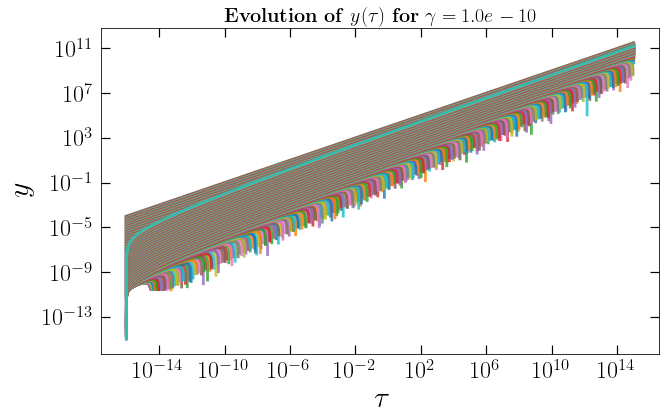

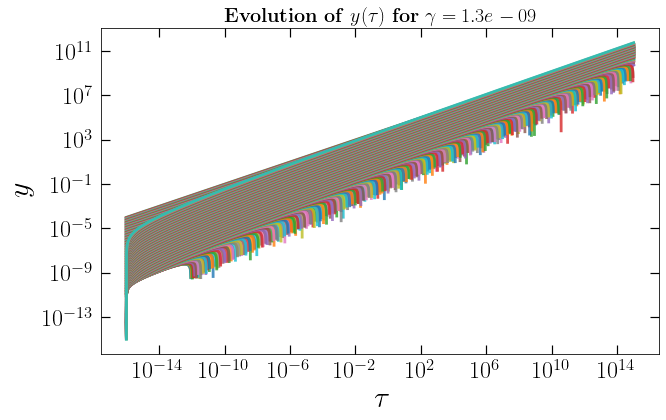

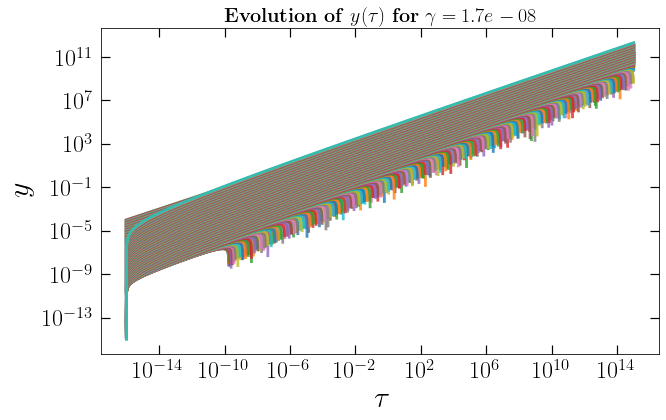

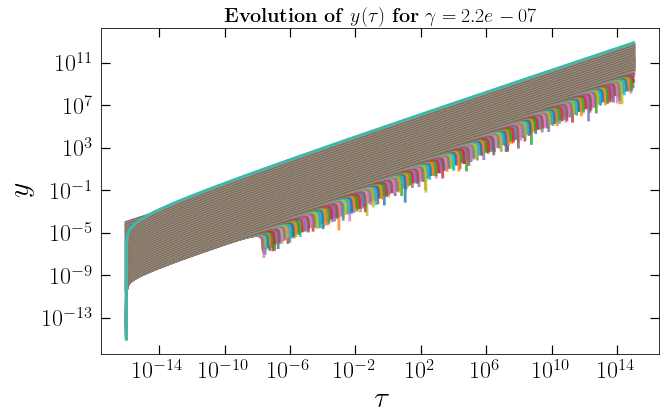

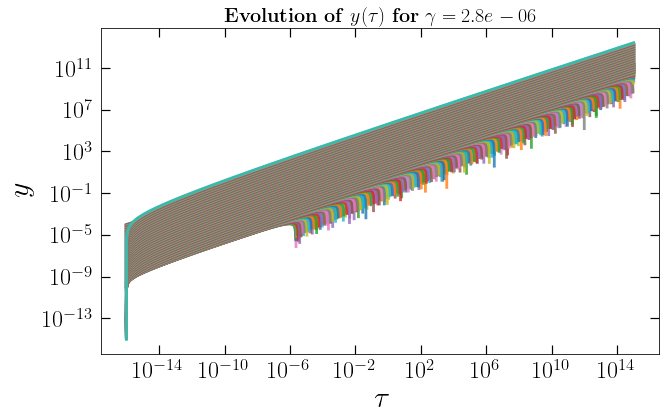

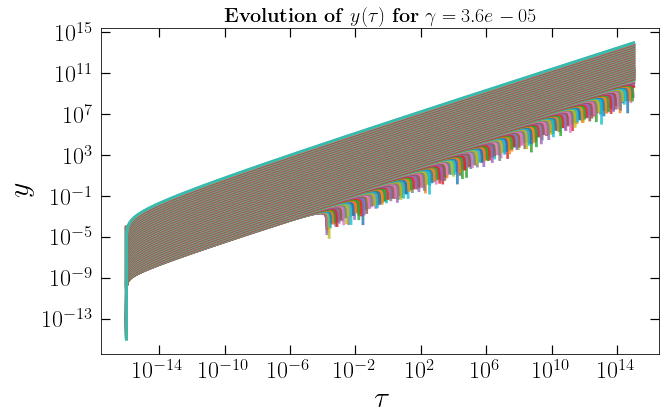

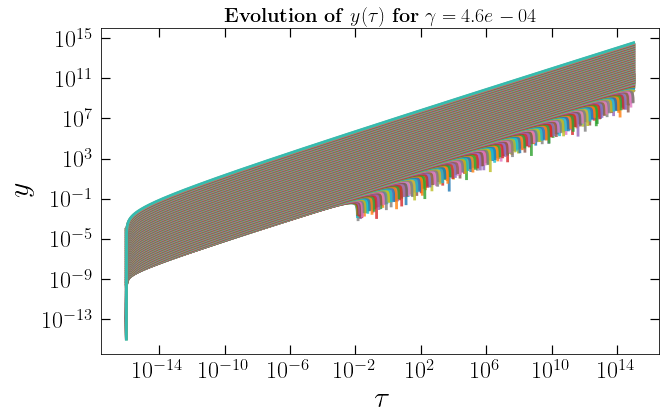

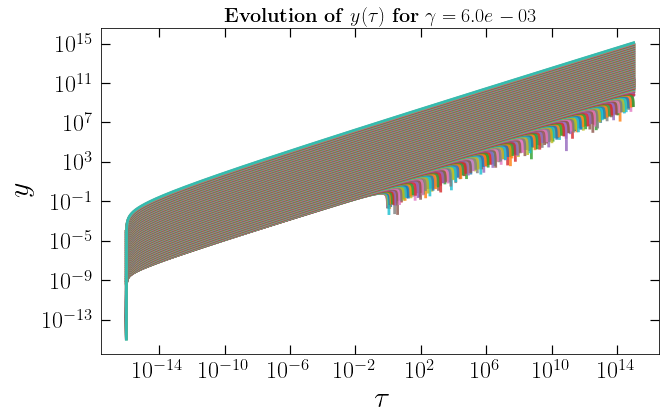

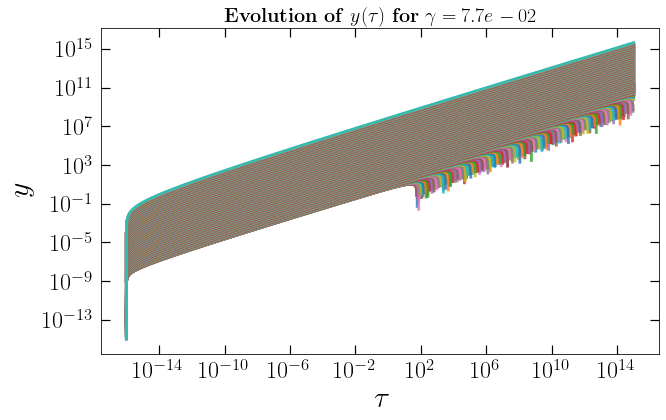

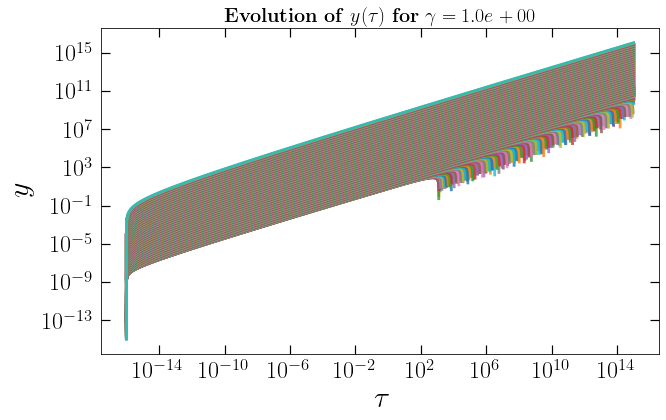

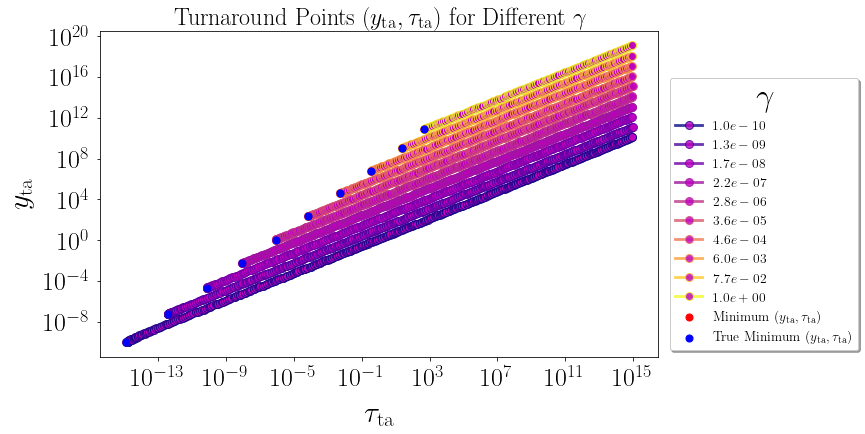

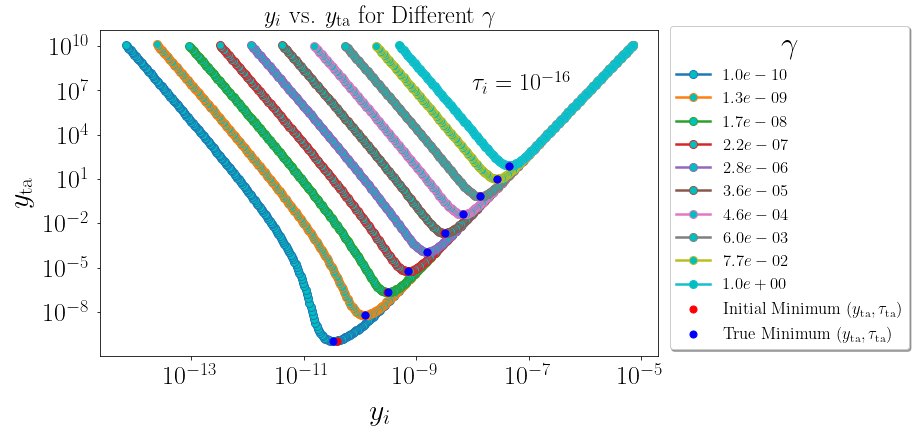

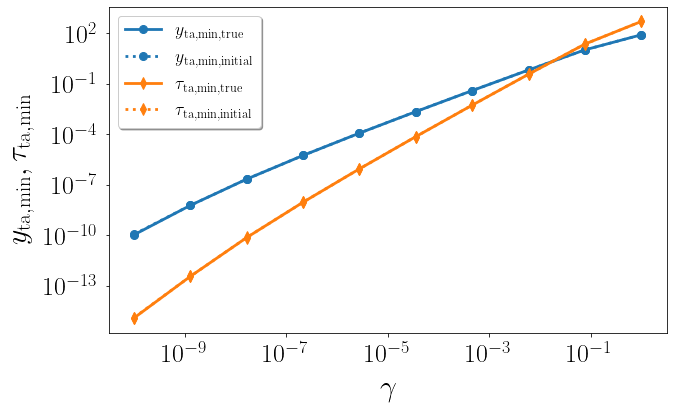


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.8474e-11, Tau_ta: 1.2604e-15, Y_ta: 1.1245e-10
Gamma: 1.3e-09, Y_i: 1.2365e-10, Tau_ta: 3.5974e-13, Y_ta: 5.9458e-09
Gamma: 1.7e-08, Y_i: 3.0830e-10, Tau_ta: 7.3123e-11, Y_ta: 2.1631e-07
Gamma: 2.2e-07, Y_i: 7.3068e-10, Tau_ta: 9.1649e-09, Y_ta: 5.5174e-06
Gamma: 2.8e-06, Y_i: 1.5645e-09, Tau_ta: 8.7794e-07, Y_ta: 1.1635e-04
Gamma: 3.6e-05, Y_i: 3.1842e-09, Tau_ta: 7.2142e-05, Y_ta: 2.2070e-03
Gamma: 4.6e-04, Y_i: 6.8182e-09, Tau_ta: 5.3432e-03, Y_ta: 3.9072e-02
Gamma: 6.0e-03, Y_i: 1.3877e-08, Tau_ta: 3.6805e-01, Y_ta: 6.5785e-01
Gamma: 7.7e-02, Y_i: 2.6845e-08, Tau_ta: 2.2715e+01, Y_ta: 1.0283e+01
Gamma: 1.0e+00, Y_i: 4.4596e-08, Tau_ta: 4.9994e+02, Y_ta: 8.0821e+01

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.2930e-11, Tau_ta: 1.2092e-15, Y_ta: 1.0577e-10
Gamma: 1.3e-09, Y_i: 1.2240e-10, Tau_ta: 3.5926e-13, Y_ta: 5.9349e-09
Gamma: 1.7e-08, Y_i: 3.1450e-10, Tau_ta: 7.2867e-11, Y_ta: 2.1603e-07
Gamma: 2.2e-

In [25]:
gamma_values = np.geomspace(1e-10, 1, 10) 
yi_values = np.geomspace(1e-4, 1e-15, 500)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
for gamma in gamma_values:
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    for y_i in yi_values:
        sol, turnaround = gamma_results[gamma][y_i] 
        tau_vals, y_vals = sol.t, sol.y[0]
        ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
#seen_points = set()  # Avoid duplicate points
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")


ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.02), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta3.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.02), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta3.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr, marker='o', markersize=8, color='C0', ls='-', label="Refined $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr, marker='d',  markersize=8, color='C1', ls='-', label="Refined $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("ytamin_vs_gamma3.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

